# Tutorial on Variational Quantum Eigensolver (Part II)
# "*Brute force*" Measurement to Estimate Energy

---
This code was mostly based on Qiskit Variational Quantum Eigensolver Playground, you can find in [Github](https://github.com/JavaFXpert/vqe-playground). Please run all the cells in order.

We saw that to estimate the energy in **Part I** we accessed the complex factors of each one of the components of the ansatz wavefunction. That is something we definitely cannot peek at in a real quantum computer. The best we can do is a meassurement and there will be probabilities to reach only one of the base states. A quantum computer is inherently probabilistic and we will need to repeat the experiment and measure several times if we want to achieve a certain degree of certainty on the validity of our results.

There are several techniques to minimize the number of experiments or to maximize the probability of getting a correct answer but nothing comes for free. The biggest the certainty the more gates and ancilla(auxiliary) qubits we will need. We are going to explore in this Tutorial simplest of all measurements. We will be directly measuring each of the qubits of the  Ansatz wavefunction.

This step now will be just a measurement and it will be reproducible in a real quantum computer. In the following figure you can see now the new elements of the algorithm differentiated in Blue (Quantum) and Green(Classical).   
<img src="./img/VQE1.2.png" >

  
## Creating the Hamiltonian, Max-Cut problem definition

In the VQE method, we will try to minimize the expectation value of a target Hamiltonian. But how do we create that target Hamiltonian for each problem?

The fundamental problem we are tackling in [Max-Cut](https://en.wikipedia.org/wiki/Maximum_cut) is the following. We have a graph which nodes are connected by non directional edges with weights $w_{ij}=w_{ji}$. We will categorize the nodes in two different subsets (red/blue, black/white, one/zero,...). We will be drawing a line in the graph that goes though all the edges that separate two different nodes. Later we add up all the weights and that will be the function to maximize.
We will try to maximaze the Cost Function (In this case 'profit' function):

$$ \tilde{C}(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j). $$

We will assign '0' or '1' as $x_i$ to define the node belonging to one subset or the other. Note that only if one node is '1' and the other is '0' the weight will be summed up. Because of the sum on i and j, also note the specific weight with be counted only once.

<img src="./img/maxcut1.png" >

This problem is known to be NP-Complete and is equivalent in physics to the minimization of the Hamiltonian of a [spin glass model](https://en.wikipedia.org/wiki/Spin_glass) of a system, more specifically the [Ising Model](https://en.wikipedia.org/wiki/Ising_model).  

How do we move from the Cost function above to a Quantum Circuit? We could replace the $x_i$ in the Cost function with a Z gate and extract its expectation value, but for a Z gate we will get an expectation value of +1 if the state is $ |0\rangle $ and an expectation value of -1 if the state is $ |1\rangle $. (Remember the Eigenvalues of a Z Matrix are [+1,-1])

Also note that using Z will be a good move as it is the gate of the computational basis and will allow us meassuring directly to get 0 or 1.

How can we transform the Cost function in a Hamiltonian that gives the same results?

We can do the following transformation:
$$ \tilde{C}(\textbf{x}) =x_{i} \rightarrow H=\frac{1}{2}\left ( 1-Z_{i} \right ) $$

and we will see that the Hamiltonian has an expectation value of 1 if the state is $ |1\rangle $, and an expectation value of 0 when the sate is $ |0\rangle $ as we want. Getting this transformation in the cost function, the resulting Hamiltonian is:

$$ H = \sum_{i,j} w_{ij} x_i (1-x_j) =\sum_{i,j} w_{ij}\frac{1}{4}\left ( 1-Z_{i} \right )\left ( 1+Z_{j} \right ) = \sum_{i,j} w_{ij}\frac{1}{4} ( 1 - Z_{i} + Z_{j} - Z_{i}Z_{j} ) $$

When we go through all the i and j things get simplified and we can reduce the sum to i<j. In that case the $Z_{i}$ and $Z_{j}$ cancel out and we can disregard the constant of the Hamiltonian as it makes for a constant Energy Value $E_{0}$ we can discard comparing Energies with one another.

$$ H =- \sum_{i<j} w_{ij}\frac{1}{4} ( Z_{i}Z_{j} + Z_{j}Z_{i} ) + E_{0}$$
$$ H =- \sum_{i<j} w_{ij}\frac{1}{2} ( Z_{i}Z_{j} ) $$

We now can proceed to map the weights of the graph and or the Adjacency Matrix to the Hamiltonian and we will get a more or less complex sum of terms with Z in two of the qubits.

We now need the expectation value of the Hamiltonian given an Ansatz Wavefunction $ |\Psi_{Ansatz}\rangle $. That will give us the Energy of the system that is represented by such Hamiltonian.

$$ \langle\Psi_{Ansatz}| H |\Psi_{Ansatz}\rangle = - \sum_{i<j} w_{ij}\frac{1}{2} ( \langle\Psi_{Ansatz}|Z_{i}Z_{j}|\Psi_{Ansatz}\rangle ) $$ 

So to calculate the Energy we will have to sum all the contributions of the expectation value of the separate Sum Terms.

As we discuss before, the Hamiltonian in this case will be an optimization Hamiltonian coming from the [Max-Cut](https://en.wikipedia.org/wiki/Maximum_cut) problem given a certain [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) with its corresponding weigths for every edge connecting to nodes. We will be working with 5 nodes this time. Each node will be represented by one Qubit. In this picture we see a proposed graph and its adjacency matrix. We will be solving for this specific Graph in this tutorial.
<img src="./img/VQE3.png" >

When we take that Matrix and or Adjacency Matrix we find 6 terms in the Hamiltonian such as:

$$ H = - \left (\frac{3}{2}Z_{1}Z_{0} + \frac{1}{2}Z_{2}Z_{0} + \frac{3}{2}Z_{3}Z_{0} + \frac{3}{2}Z_{3}Z_{2} + \frac{2}{2}Z_{4}Z_{1} + \frac{2}{2}Z_{4}Z_{3}\right ) $$

Also note that for example $Z_{1}Z_{0}=I_{4}I_{3}I_{2}Z_{1}Z_{0}$ with $I$ being the identity matrix and that this term of the Hamiltonian will be a 100% diagonal Matrix.

As we claimed before, we will have to sum all the expectation values of the 6 terms in the sum, so taking the previous term as an example and calling it $H^{(1)}$:

$$ \langle\Psi|H^{(1)}|\Psi\rangle = - \frac{3}{2}\langle\Psi|I_{4}I_{3}I_{2}Z_{1}Z_{0}|\Psi\rangle  $$

Lets assume that the wave function is composed by following complex terms in the computational basis $|i\rangle $:

$$ |\Psi\rangle = \sum_{i} C_{i}|i\rangle $$
Substituting in the previous equation:
$$ \langle\Psi|H^{(1)}|\Psi\rangle = - \frac{3}{2}\sum_{i} |C_{i}|^2 \lambda_{i}^{(1)} =  - \frac{3}{2}\sum_{i} P_{i} \lambda_{i}^{(1)}  $$

Where $\lambda_{i}$ are the eigenvalues of the Matrix $I_{4}I_{3}I_{2}Z_{1}Z_{0}$ and $P_{i}$ are the probabilities of wach one of the basis states $|i\rangle $. Now we just have to measure the 5 qubits of the $|\Psi_{Ansatz}\rangle$ and get a probability distributions of each one of the basis states on the computational basis. Targeting around 1000 experiments will give us quite an accurate probability distribution to be able to calculate the expectation value of this term of the Hamiltonian.

What we are going to do is sum up all the eigenvalues with corresponding weights in this manner:

$$ \langle\Psi|H|\Psi\rangle = - \sum_{i} P_{i} \left (\frac{3}{2}\lambda_{i}^{(1)}+..+ \frac{2}{2}\lambda_{i}^{(6)}\right ) $$

so they will be ready to calculate the Energy each time we have a new $|\Psi_{Ansatz}\rangle $ with new $P_{i}$.

Note that we are not using the max_cut libraries this time, and we are getting the eigenvalues from each one of the terms that we will calculate as matrices. Also we are not getting access to the wavefunction internally, and instead we are measuring the quibits to get an estimation of the probabilities that we will use to get the energy. This measurement (1024 times in this example for each of the trial ansatz wavefunction, is what we call "Brute Force".


## Import libraries  

We import all necessary functions from IBM qiskit and numpy python **libraries**, that we will later use on this Notebook.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram

print("Libraries loaded successfully.")

Libraries loaded successfully.


## Definition of the Circuit
We already went through the details of classes `CircuitGridNode` and `CircuitGridModel` in PART I 

In [2]:
class CircuitGridNode():
    def __init__(self, node_type, radians=0.0, ctrl_a=-1):
        self.node_type = node_type
        self.radians = radians
        self.ctrl_a = ctrl_a
        self.wire_num = -1
        self.column_num = -1

For the Class: **`CircuitGridModel`** , we are going to add the extra Quantum Circuit necessary to do the Hamiltonian expectation value and the corresponding measurement. In this 'Brute Force' PartII tutorial we will just meassure the 5 qubits. 

Hence we are not adding extra quibits or Gates in the initialization segment now.

In [3]:
class CircuitGridModel():

    def __init__(self):
        # Define the Quantum Circuit to generate the Ansatz + Other Measurement Circuit
        self.max_wires = NUM_QUBITS
        self.max_columns = 21            # Columns for the circuit. 21 Columns for the Entanglement/Tuning Circuit
        self.nodes = np.empty((self.max_wires, self.max_columns),
                                dtype = CircuitGridNode)
        
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                if column_num % 5 == 0:
                    self.nodes[wire_num][column_num] = CircuitGridNode(Ygate, np.pi)              # Ry(pi)
                    self.nodes[wire_num][column_num].wire_num = wire_num
                    self.nodes[wire_num][column_num].column_num = column_num
                else: 
                    if wire_num != 0 and wire_num == column_num % 5:
                        self.nodes[wire_num][column_num] = CircuitGridNode(Xgate, 0, wire_num-1)  # CNOT 
                        self.nodes[wire_num][column_num].wire_num = wire_num
                        self.nodes[wire_num][column_num].column_num = column_num
        
        # Measurement part of the Circuit 
        # Not applicable in Brute Force

    def get_rotation_gate_nodes(self):
        rot_gate_nodes = []
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node and node.node_type == Ygate:
                    rot_gate_nodes.append(node)
        return rot_gate_nodes
    
    def compute_circuit(self):
        qr = QuantumRegister(NUM_QUBITS, 'q')
        cr = ClassicalRegister(NUM_QUBITS, 'c')
        qc = QuantumCircuit(qr, cr)
        # Build the Circuit with actual gates based on the Circuit Grid Model
        for column_num in range(self.max_columns):
            qc.barrier(qr)
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node:
                    if node.node_type == Xgate:    qc.cx(node.ctrl_a, wire_num)   # Controlled X gate
                    elif node.node_type == Ygate:  qc.ry(node.radians, wire_num)      # Rotation around Y axis
        
        # Add Measurement at the end
        qc.measure(qr, cr) 
        
        return qc


## Eigenvalues, Quantum State and Expectation Values

Now in this section of the code we will calculate the Hamiltonian Matrices for each one of the 6 terms. Note that the resulting 32x32 matrix $(2^5x2^5)$ will be diagonal. This happens because the Hamiltonian has only Z and I matrices (that are in turn diagonal) and stay in the computational basis. We will extract the eigenvalues directly from that diagonal to calculate the expectation value. 

In [4]:
# Build the each Term of the hamiltonian doing the kronecker product of I and Z 
# H1 = (3/2)Z0Z1   ;   H2 = (1/2)Z0Z2   ;   H3 = (3/2)Z0Z3
# H4 = (3/2)Z2Z3   ;   H5 = (2/2)Z1Z4   ;   H6 = (2/2)Z3Z4 
I=[[1,0], [0,1]]
Z=[[1,0], [0,-1]]
II=np.kron(I,I)
ZZ=np.kron(Z,Z)
ZI=np.kron(Z,I)
IZ=np.kron(I,Z)
IIIZZ=np.diag(np.kron(I,np.kron(II,ZZ)))
IIZIZ=np.diag(np.kron(I,np.kron(IZ,IZ)))
IZIIZ=np.diag(np.kron(I,np.kron(ZI,IZ)))
IZZII=np.diag(np.kron(I,np.kron(ZZ,II)))
ZIIZI=np.diag(np.kron(Z,np.kron(II,ZI)))
ZZIII=np.diag(np.kron(ZZ,np.kron(II,I)))
    
# Extract the Eigenvalues in the Diagonal for each Term and multiply by corresponding factor 
Eigen_1=[(3/2)*float(i) for i in IIIZZ]
Eigen_2=[(1/2)*float(i) for i in IIZIZ]
Eigen_3=[(3/2)*float(i) for i in IZIIZ]
Eigen_4=[(3/2)*float(i) for i in IZZII]
Eigen_5=[(2/2)*float(i) for i in ZIIZI]
Eigen_6=[(2/2)*float(i) for i in ZZIII]   
Eigen_SUM=[Eigen_1[i]+Eigen_2[i]+Eigen_3[i]+Eigen_4[i]+Eigen_5[i]+Eigen_6[i] for i in range(32)]

## Global Functions:

This list of function will do the following:

* `ExperimentAndMeasure` Sets up the Qiskit Simulator, Executes the simulation `n_experiments` times and return the results as an histogram (dictionary of results in the format: {'000': n1, '001': n2 ....}).
* `dict_to_array` translates previous dictionary to an array of probabilities $P_i$
* `calc_expectation_value` uses the probability distribution and the eigenvalues to calculate Energy. 

In [5]:
def ExperimentAndMeasure(circuit):
   
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(circuit, backend_sim, shots=n_experiments)
    result_sim = job_sim.result()
    prob_distro = result_sim.get_counts(circuit)
    print("Ansatz:",prob_distro)

    # Measure and store in prob_distro in the format: {'000': 524, '111': 500}
    return prob_distro

def dict_to_array(prob_distro):
    Prob_i=[]
    for name in basis_states:
        prob_distro.setdefault(name, 0)
        Prob_i.append(float(prob_distro.get(name))/n_experiments)
    return Prob_i
    
def calc_expectation_value(prob_distro):
    Prob_i = dict_to_array(prob_distro)
    new_energy = np.dot(Eigen_SUM,Prob_i)
    return new_energy, prob_distro, np.argmax(Prob_i)

## Global Function to Recalculate Circuit and Recalculate Expectation Value 
This function will first make use of the array `optimized_rotations` that hold the latest optimal angles for all the Ry Gates. It will assign those angles to the nodes contained in `rotation_gate_nodes` which are the nodes in the circuit subject to rotation (Ry).

After that, it will compute the new circuit in the Class `circuit_grid_model` and will obtain the ansatz state and Measure it correspondingly with `ExperimentAndMeasure`. 

That function will in turn give the probability distribution that will be input in the `calc_expectation_value` function that at last will return the estimated Energy, most probable base state and the actual probability distribution as well.

In [6]:
def calc_new_energy(circuit_grid_model, rotation_gate_nodes):

    for idx in range(len(rotation_gate_nodes)):
        rotation_gate_nodes[idx].radians = optimized_rotations[idx]
    
    quantumcircuit = circuit_grid_model.compute_circuit()
    prob_distro = ExperimentAndMeasure(quantumcircuit)
    
    return calc_expectation_value(prob_distro)

## Global Function to Optimize Rotations
This function will contain the **classical optimization algorithm** to finetune the angles and make sure that the Energy of the resulting state will be minimal.

As input it will gate the, the Class with the Circuit, the Class with the Expectation grid and the array of nodes with Ry Gates. As output it will proyect the latest optimized energy the variable `energy` and the latest *optimal* basis state (basis state with highest probability) 

`cur_rotation_num` will be the node containing the Ry Gate currently being updated and optimized. Will be a counter 25 times. For each gate, the algorithm will start rotating a fixed angle on one direction, if the Energy stays or decreasis it will continue rotating, if it increases, then it will change direction of rotation unless it already changed direction before. In that case or if the angle is out of the $ [0,2\pi] $ range, it will move to the next gate.  

In [7]:
def optimize_rotations(circuit_grid_model, rotation_gate_nodes):
    global energy, move_radians, cur_rotation_num, rot_direction, prob_distro, maxindex, Fin_optimizacion

    if cur_rotation_num < len(optimized_rotations):   # Are we on the last Ry Gate?
        cur_ang_rad = optimized_rotations[cur_rotation_num]
        proposed_cur_ang_rad = cur_ang_rad
        proposed_cur_ang_rad += move_radians * rot_direction
        
        if (0.0 <= proposed_cur_ang_rad <= np.pi * 2 + 0.01) and (num_times_rot_dir_change[cur_rotation_num]<2):
            optimized_rotations[cur_rotation_num] = proposed_cur_ang_rad               
            
            # Calculate new Energy with the new Circuit, Quantum Qiskit circuit is called here.
            temp_energy, prob_distro, maxindex = calc_new_energy(circuit_grid_model, rotation_gate_nodes)
            if temp_energy > energy: 
                # NOT OPTIMIZED. Distance is increasing so restore the angle and change direction of rot
                optimized_rotations[cur_rotation_num] = cur_ang_rad
                rot_direction *= -1
                num_times_rot_dir_change[cur_rotation_num] += 1
            else:
                # OPTIMIZED or equal. Distance decreasing, so keep the proposed angle and update Energy
                energy = temp_energy
        else:                                       
            cur_rotation_num += 1       # Out of [0,2pi] range or changed direction twice. Move to next Gate.
    else:
        Fin_optimizacion = True         # We reached the last Ry, optimization process is over    
    
    return energy, prob_distro, maxindex

## Definitions and Initializations
In this segment of code we will initialize global variables that will be used in the Main and optimization algorithm. One of the important variables is the Rotation step. Note the Adjacency Matrix does not show up as it is embedded in the Hamiltonian we have manually calculated.

In [12]:
NUM_QUBITS = 5                                        # Qubits to model the problem
Xgate = 1 ; Ygate = 2 ; Zgate = 3                     # Gate Definitions    
basis_states = []                                     # List of Basis states in Text format
for idx in range(2**NUM_QUBITS):
    state = format(idx, '0' + str(NUM_QUBITS) + 'b')
    basis_states.append(state)
    
n_experiments = 1024
maxindex = None
cur_rotation_num = 0
proposed_cur_ang_rad = 0
cur_ang_rad = 0
rot_direction = 1
iteration=0
Fin_optimizacion = False  
move_radians = np.pi / 8                             # Rotation Step

## Initialization of the Circuit and Visual Output
Here we will initialize the circuit for first time and will calculate the Ansatz State of the all the Ry gates with $\pi$ radians. Also it will create the expectation grid for the first time.

When the expectation grid is initialized, it will convert the Adjacency matrix to the Ising Hamiltonian and will print its output in gate format (I and Z gates)

On this piece of code we also print the Quantum Optimization Circuit using the Qiskit drawing capabilities as well as the Latex output extensions included in the Qiskit programming language to show the Adjacency Matrix in a readable manner.


Complete Quantum Circuit:


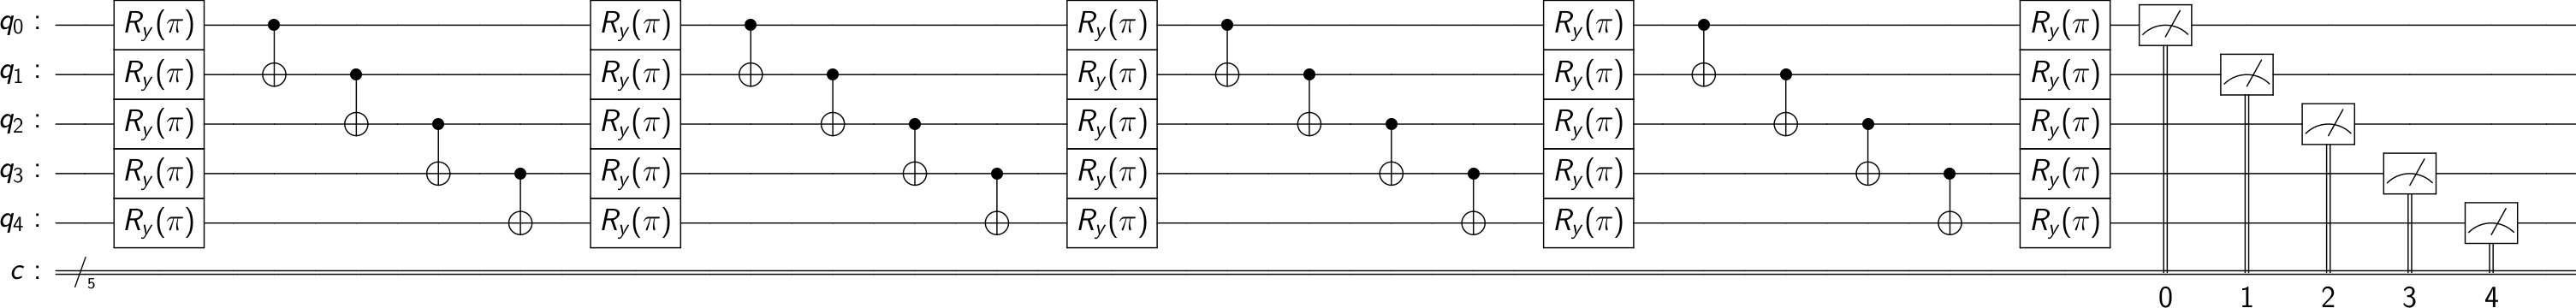

In [9]:
circuit_grid_model = CircuitGridModel()
circuit = circuit_grid_model.compute_circuit()

print("\nComplete Quantum Circuit:")
display(circuit.draw(output='latex',scale=0.7,plot_barriers=False))

## Main Loop and Print Results
First extract all nodes with gates suitable for rotation ans intialize first rotation of those with $\pi$. At the beginning, all Ry Gates will be indeed Pauli Y Gates.

After that we will run the first Optimization iteration befor going to the actual main loop.

In the main loop showing as a `while` we will **print** the Iteration number, the rotating gate, the position in the 5x21 matrix, the energy of this iteration, and the optimal basis state so far.

Then we will try to **optimize** calling `optimize_rotations` function. During the optimization we will also print the simulated Ansatz State that results after the optimization quantum circuit. The output will be a **sum of the basis states and its probability**.

Once the optimization comes to an end and we get out of the loop we will print the final Energy and Optimal Base State as a result

In [13]:
# INITIALIZATION OF FIRST CIRCUIT AND FIRST ENERGY
rotation_gate_nodes = circuit_grid_model.get_rotation_gate_nodes()
optimized_rotations = np.full(len(rotation_gate_nodes), np.pi)
num_times_rot_dir_change = np.zeros(len(optimized_rotations))

energy, prob_distro, maxindex = calc_new_energy(circuit_grid_model, rotation_gate_nodes)

# MAIN OPTIMIZATION LOOP    
while not Fin_optimizacion:
    if cur_rotation_num != len(optimized_rotations):
        print(' Iteration #' + str(iteration+1) , ', Rotating Gate #' , str(cur_rotation_num+1) , 
        '(Wire, Column) = (', rotation_gate_nodes[cur_rotation_num].wire_num+1, ',' , 
        rotation_gate_nodes[cur_rotation_num].column_num+1, '). Energy:', "{:.6f}".format(energy),
        ', Best Basis State:', basis_states[maxindex], "\n")
        #print(' Ansatz:',prob_distro,"\n")
    energy, prob_distro, maxindex = optimize_rotations(circuit_grid_model, rotation_gate_nodes)
    iteration +=  1
    #print (optimized_rotations)

# PRINT FINAL RESULT        
print("\n-------------------------------------------------------- \n")
print('Final Energy: ', "{:.6f}".format(np.real(energy)), ', Optimal Basis State:', basis_states[maxindex])
print("\n-------------------------------------------------------- \n")
print('Ansatz:',prob_distro)
print("\n-------------------------------------------------------- \n")

Ansatz: {'00111': 1024}
 Iteration #1 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.000000 , Best Basis State: 00111 

Ansatz: {'10110': 36, '00111': 988}
 Iteration #2 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.035156 , Best Basis State: 00111 

Ansatz: {'10110': 145, '00111': 879}
 Iteration #3 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.141602 , Best Basis State: 00111 

Ansatz: {'10110': 322, '00111': 702}
 Iteration #4 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.314453 , Best Basis State: 00111 

Ansatz: {'10110': 534, '00111': 490}
 Iteration #5 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.521484 , Best Basis State: 10110 

Ansatz: {'10110': 706, '00111': 318}
 Iteration #6 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.689453 , Best Basis State: 10110 

Ansatz: {'10110': 875, '00111': 149}
 Iteration #7 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.854492 , Best Basis State: 10110 


 Iteration #61 , Rotating Gate # 15 (Wire, Column) = ( 5 , 11 ). Energy: -6.000000 , Best Basis State: 10101 

Ansatz: {'10101': 996, '00101': 28}
 Iteration #62 , Rotating Gate # 15 (Wire, Column) = ( 5 , 11 ). Energy: -6.000000 , Best Basis State: 10101 

Ansatz: {'10101': 986, '00101': 38}
 Iteration #63 , Rotating Gate # 15 (Wire, Column) = ( 5 , 11 ). Energy: -6.000000 , Best Basis State: 10101 

 Iteration #64 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.000000 , Best Basis State: 10101 

Ansatz: {'10101': 981, '01010': 43}
 Iteration #65 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.000000 , Best Basis State: 10101 

Ansatz: {'10101': 878, '01010': 146}
 Iteration #66 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.000000 , Best Basis State: 10101 

Ansatz: {'10101': 706, '01010': 318}
 Iteration #67 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.000000 , Best Basis State: 10101 

Ansatz: {'10101': 503, '01010': 521}
 Ite

## Histogram of Ansatz Measurements

Histogram: 


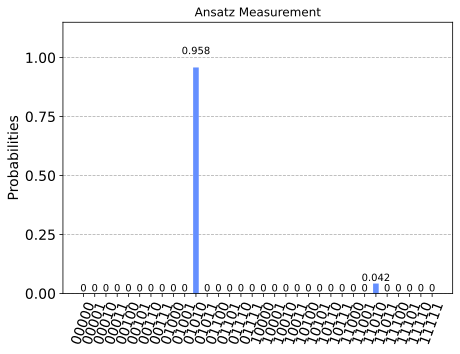

In [14]:
print('Histogram: ')
plot_histogram(prob_distro, title="Ansatz Measurement")